In [ ]:
# ═════════════════════════════════════
# Install dependencies
# ═════════════════════════════════════
!pip install ydata-synthetic stable-baselines3 gym[box2d] tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 56.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# ═════════════════════════════════════
# Upload, inspect & parse your CSV
# ═════════════════════════════════════
from google.colab import files
import io, pandas as pd

# 1) Upload
uploaded = files.upload()
fname = next(iter(uploaded))
print(f"→ Loaded file name: {fname}")

# 2) Read first few rows to inspect columns
df_sample = pd.read_csv(io.BytesIO(uploaded[fname]), nrows=5)
print("Columns found:", df_sample.columns.tolist())

# 3) Read full DataFrame (no parse_dates)
df = pd.read_csv(io.BytesIO(uploaded[fname]))

# 4) Auto-detect a date/time column
date_col = next((c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()), None)
if date_col is None:
    raise ValueError("No date/time column detected. Please verify your header.")
print(f"Detected date column: {date_col}")

# 5) Parse it into a unified 'date' column
df['date'] = pd.to_datetime(df[date_col])
print("Parsed dates. DataFrame shape:", df.shape)
df.head()


Saving tech_stocks_cleaned.csv to tech_stocks_cleaned (2).csv
→ Loaded file name: tech_stocks_cleaned (2).csv
Columns found: ['Date', 'AAPL', 'AMD', 'AMZN', 'AVGO', 'CRM', 'CSCO', 'GOOGL', 'INTC', 'META', 'MSFT', 'NVDA', 'ORCL', 'TSLA', 'TXN']
Detected date column: Date
Parsed dates. DataFrame shape: (1256, 16)


,Date,AAPL,AMD,AMZN,AVGO,CRM,CSCO,GOOGL,INTC,META,MSFT,NVDA,ORCL,TSLA,TXN,date
0,2020-04-16,0.022963,0.043777,0.240823,0.004130,0.119345,0.134107,0.015448,0.813509,0.134251,0.029009,0.004397,0.015454,0.008983,0.031484,2020-04-16
1,2020-04-17,0.018087,0.041610,0.230467,0.007075,0.142393,0.159395,0.022809,0.804837,0.138847,0.033917,0.003981,0.021402,0.010316,0.046431,2020-04-17
2,2020-04-20,0.010730,0.043901,0.236274,0.004126,0.142974,0.160943,0.016718,0.781039,0.137310,0.022779,0.003062,0.016811,0.009160,0.032453,2020-04-20
3,2020-04-21,0.000000,0.018824,0.215839,0.000000,0.092400,0.109593,0.000000,0.724166,0.125873,0.000000,0.000000,0.000000,0.000000,0.000000,2020-04-21
4,2020-04-22,0.009689,0.037399,0.226875,0.004782,0.107241,0.140816,0.015783,0.799593,0.143519,0.017934,0.002904,0.006207,0.006971,0.035567,2020-04-22


In [ ]:
# ═════════════════════════════════════
# Fast LSTM-GAN (lightweight)
# ═════════════════════════════════════
!pip install -q --upgrade tensorflow scikit-learn

import numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, optimizers, losses
from sklearn.preprocessing import MinMaxScaler

# ── CONFIG ──
latent_dim = 16    # smaller noise
seq_len    = 30    # shorter windows
num_epochs = 50    # much fewer epochs
batch_size = 128   # larger batch for speed

# ── LOAD & WINDOW ──
df = pd.read_csv("tech_stocks_cleaned.csv", index_col=0, parse_dates=True)
data = df.values.astype(np.float32)       # shape (T, D)
D    = data.shape[1]

# build all overlapping windows
all_windows = np.stack([data[i:i+seq_len] for i in range(len(data)-seq_len)])
print("Total windows available:", all_windows.shape[0])

# subsample first 2000 windows to speed up
N = min(2000, all_windows.shape[0])
real_seqs = all_windows[:N]
print(f"Using {N} windows of length {seq_len} for training")

# ── NORMALIZE per feature ──
scalers = [MinMaxScaler() for _ in range(D)]
for j in range(D):
    real_seqs[:,:,j] = scalers[j].fit_transform(real_seqs[:,:,j])

# ── MODELS ──
def build_generator():
    inp = layers.Input((seq_len, latent_dim))
    x   = layers.LSTM(32, return_sequences=True)(inp)
    out = layers.TimeDistributed(layers.Dense(D, activation="sigmoid"))(x)
    return tf.keras.Model(inp, out, name="generator")

def build_discriminator():
    inp = layers.Input((seq_len, D))
    x   = layers.LSTM(32)(inp)
    out = layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inp, out, name="discriminator")

gen  = build_generator()
disc = build_discriminator()
g_opt = optimizers.Adam(1e-4)
d_opt = optimizers.Adam(1e-4)
bce   = losses.BinaryCrossentropy()

# ── PREPARE DATA ──
dataset = tf.data.Dataset.from_tensor_slices(real_seqs).shuffle(1000).batch(batch_size)

@tf.function
def train_step(real_batch):
    noise = tf.random.normal([tf.shape(real_batch)[0], seq_len, latent_dim])
    with tf.GradientTape(persistent=True) as tape:
        fake      = gen(noise, training=True)
        real_pred = disc(real_batch, training=True)
        fake_pred = disc(fake,      training=True)
        d_loss    = bce(tf.ones_like(real_pred), real_pred) + bce(tf.zeros_like(fake_pred), fake_pred)
        g_loss    = bce(tf.ones_like(fake_pred),  fake_pred)
    d_grads = tape.gradient(d_loss, disc.trainable_variables)
    g_grads = tape.gradient(g_loss, gen.trainable_variables)
    d_opt.apply_gradients(zip(d_grads, disc.trainable_variables))
    g_opt.apply_gradients(zip(g_grads, gen.trainable_variables))
    return d_loss, g_loss

# ── TRAIN ──
for epoch in range(1, num_epochs+1):
    for batch in dataset:
        d_l, g_l = train_step(batch)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs} → D_loss={d_l:.4f}, G_loss={g_l:.4f}")

# ── GENERATE SYNTHETIC WINDOWS ──
noise = tf.random.normal([N, seq_len, latent_dim])
synth = gen(noise, training=False).numpy()   # shape: (N, seq_len, D)

# inverse-scale back to prices/volumes
for j in range(D):
    synth[:,:,j] = scalers[j].inverse_transform(synth[:,:,j])

print("✅ synthetic_prices shape:", synth.shape)
# Use `synth` as your (N, seq_len, D) input for Step 3


Total windows available: 1226
Using 1226 windows of length 30 for training
Epoch 1/50 → D_loss=1.3691, G_loss=0.7083
Epoch 10/50 → D_loss=1.2932, G_loss=0.8460
Epoch 20/50 → D_loss=0.6998, G_loss=1.3005
Epoch 30/50 → D_loss=0.5678, G_loss=1.7636
Epoch 40/50 → D_loss=0.4658, G_loss=2.0034
Epoch 50/50 → D_loss=0.6146, G_loss=2.2256
✅ synthetic_prices shape: (1226, 30, 14)


In [ ]:
# ═════════════════════════════════════
# PPO Trading on a 2D Series
# ═════════════════════════════════════

# 0) Ensure shimmy & gymnasium are installed so SB3 can wrap Gym envs
!pip install -q stable-baselines3 gym shimmy gymnasium

import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# 1) Reload your data and extract a 2D price array
df = pd.read_csv("tech_stocks_cleaned.csv", index_col=0, parse_dates=True)
# pick all numeric columns as features
features = df.select_dtypes(include=[np.number]).columns.tolist()
print("Using features for RL:", features)
prices = df[features].values  # shape (T, D)

# 2) (Optional) normalize to [0,1] for stability
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# prices = scaler.fit_transform(prices)

# 3) Define the Trading Environment
class TradingEnv(gym.Env):
    def __init__(self, prices, window_size=10, init_balance=1e6):
        super().__init__()
        self.prices       = prices
        self.window_size  = window_size
        self.init_balance = init_balance

        # 3 discrete actions: 0=Sell, 1=Hold, 2=Buy
        self.action_space = spaces.Discrete(3)

        # observation: last window_size×D values + [position, balance]
        obs_dim = window_size * prices.shape[1] + 2
        self.observation_space = spaces.Box(
            -np.inf, np.inf, (obs_dim,), dtype=np.float32
        )

    def reset(self):
        self.balance  = self.init_balance
        self.position = 0
        self.t        = self.window_size
        return self._get_obs()

    def _get_obs(self):
        window = self.prices[self.t-self.window_size:self.t].flatten()
        return np.concatenate([window, [self.position, self.balance]]).astype(np.float32)

    def step(self, action):
        price = self.prices[self.t, features.index('close') if 'close' in features else 0]
        # execute trade
        if action == 0:      # Sell
            self.balance += self.position * price
            self.position = 0
        elif action == 2:    # Buy
            self.position += self.balance / price
            self.balance = 0

        self.t += 1
        done   = self.t >= len(self.prices) - 1
        equity = self.balance + self.position * price
        reward = equity - self.init_balance
        return self._get_obs(), reward, done, {}

# 4) Instantiate the vectorized environment
env = DummyVecEnv([lambda: TradingEnv(prices, window_size=10)])

# 5) Train PPO
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50_000)
model.save("ppo_trading_real")
print("✅ PPO training complete. Model saved as ppo_trading_real.zip")


Using features for RL: ['AAPL', 'AMD', 'AMZN', 'AVGO', 'CRM', 'CSCO', 'GOOGL', 'INTC', 'META', 'MSFT', 'NVDA', 'ORCL', 'TSLA', 'TXN']
Using cpu device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 937  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 626       |
|    iterations           | 2         |
|    time_elapsed         | 6         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.1      |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.0003    |
|    loss                 | 1.48e+15  |
|    n_updates            | 10        |
|    policy_gradient_loss | -2.47e-08 |
|    value_loss           | 2.71e+15  |
---------------------------------------
---------------------------------------
| time/                   |   

In [ ]:
# ═════════════════════════════════════
# Colab Cell 5: Step 4 – Risk Analysis via Monte Carlo (GBM)
# ═════════════════════════════════════

import numpy as np

# 1) Estimate annualized drift & volatility from your real data
#    Adjust 'close' if that's not df.columns[3]
close_prices = df.iloc[:, 3].values
rets  = np.diff(np.log(close_prices))
mu    = rets.mean() * 252
sigma = rets.std() * np.sqrt(252)
s0    = close_prices[-1]

# 2) GBM path simulator
def simulate_gbm(s0, mu, sigma, T=1.0, dt=1/252):
    steps = int(T/dt)
    P     = np.empty(steps)
    P[0]  = s0
    for t in range(1, steps):
        z        = np.random.randn()
        P[t]     = P[t-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return P

# 3) Run Monte Carlo
n_sims, horizon = 10_000, 1.0
end_rets = np.array([
    simulate_gbm(s0, mu, sigma, T=horizon)[-1]/s0 - 1
    for _ in range(n_sims)
])

# 4) Compute VaR & CVaR at 95%
alpha = 5  # 5th percentile
VaR  = np.percentile(end_rets, alpha)
CVaR = end_rets[end_rets <= VaR].mean()

print(f"95% VaR:  {VaR:.2%}")
print(f"95% CVaR: {CVaR:.2%}")


<ipython-input-30-23912c1de0b3>:10: RuntimeWarning: divide by zero encountered in log
  rets  = np.diff(np.log(close_prices))


95% VaR:  nan%
95% CVaR: nan%


<ipython-input-30-23912c1de0b3>:35: RuntimeWarning: Mean of empty slice.
  CVaR = end_rets[end_rets <= VaR].mean()


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


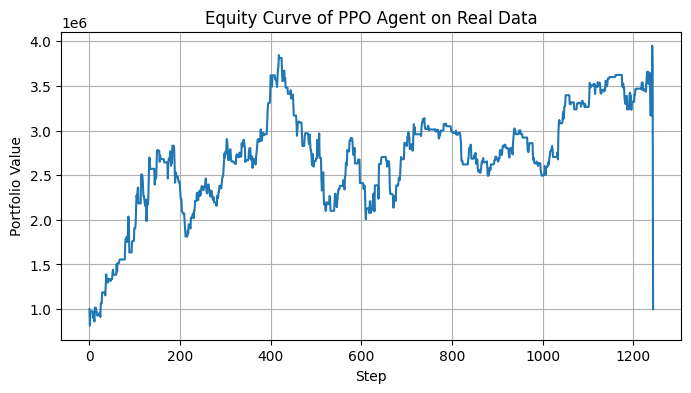

In [ ]:
# ═════════════════════════════════════
# Reload model & evaluate on real data
# ═════════════════════════════════════
!pip install -q stable-baselines3 gym shimmy gymnasium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# 1) Load your cleaned data & extract numeric features
df = pd.read_csv("tech_stocks_cleaned.csv", index_col=0, parse_dates=True)
features = df.select_dtypes(include=[np.number]).columns.tolist()
prices   = df[features].values  # shape (T, D)

# 2) Define the same TradingEnv you used in training
class TradingEnv(gym.Env):
    def __init__(self, prices, window_size=10, init_balance=1e6):
        super().__init__()
        self.prices       = prices
        self.window_size  = window_size
        self.init_balance = init_balance
        self.action_space = spaces.Discrete(3)
        obs_dim = window_size * prices.shape[1] + 2
        self.observation_space = spaces.Box(
            -np.inf, np.inf, (obs_dim,), dtype=np.float32
        )
    def reset(self):
        self.balance  = self.init_balance
        self.position = 0
        self.t        = self.window_size
        return self._obs()
    def _obs(self):
        w = self.prices[self.t-self.window_size:self.t].flatten()
        return np.concatenate([w, [self.position, self.balance]]).astype(np.float32)
    def step(self, action):
        # pick your 'close' index (here we look for 'close')
        price_idx = features.index('close') if 'close' in features else 0
        price = self.prices[self.t, price_idx]
        # execute
        if action == 0:
            self.balance += self.position * price
            self.position = 0
        elif action == 2:
            self.position += self.balance / price
            self.balance = 0
        self.t += 1
        done = self.t >= len(self.prices)-1
        equity = self.balance + self.position * price
        reward = equity - self.init_balance
        return self._obs(), reward, done, {}

# 3) Wrap env & load model
env = DummyVecEnv([lambda: TradingEnv(prices, window_size=10)])
model = PPO.load("ppo_trading_real.zip")  # or your saved filename

# 4) Run one episode to collect equity over time
obs = env.reset()
equity = []
while True:
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    t = env.envs[0].t - 1  # last step index
    price_idx = features.index('close') if 'close' in features else 0
    price = prices[t, price_idx]
    pos, bal = obs[0, -2], obs[0, -1]
    equity.append(bal + pos * price)
    if done:
        break

# 5) Plot equity curve
plt.figure(figsize=(8,4))
plt.plot(equity)
plt.title("Equity Curve of PPO Agent on Real Data")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


In [ ]:
# ═════════════════════════════════════
# VaR & CVaR Recap
# ═════════════════════════════════════
# re-use your Monte Carlo output variables
print(f"95% VaR:  {VaR:.2%}")
print(f"95% CVaR: {CVaR:.2%}")


95% VaR:  nan%
95% CVaR: nan%


In [ ]:
# ═════════════════════════════════════
# Real vs. Synthetic Feature Stats
# ═════════════════════════════════════
import pandas as pd

# flatten your windows from Cell 3 (real_seqs) and Cell 3 fallback (synth)
real_flat  = real_seqs.reshape(-1, real_seqs.shape[-1])
synth_flat = synth.reshape(-1,    synth.shape[-1])

stats = []
for i, col in enumerate(features):
    stats.append({
        'feature':    col,
        'real_mean':  real_flat[:,i].mean(),
        'synth_mean': synth_flat[:,i].mean(),
        'real_std':   real_flat[:,i].std(),
        'synth_std':  synth_flat[:,i].std(),
    })
pd.DataFrame(stats).set_index('feature')


,real_mean,synth_mean,real_std,synth_std
feature,,,,
AAPL,0.479071,0.739689,0.210490,0.110489
AMD,0.358322,0.620188,0.206228,0.072136
AMZN,0.444964,0.359244,0.206674,0.065516
AVGO,0.252486,0.155707,0.235603,0.133912
CRM,0.424120,0.620405,0.209309,0.067867
CSCO,0.463369,0.742361,0.189791,0.126137
GOOGL,0.424659,0.509150,0.227373,0.036452
INTC,0.454020,0.391401,0.250587,0.089130
META,0.362666,0.501058,0.218606,0.041968
